**Requirement:**
glob2, numpy, matplotlib, opencv-python

In [36]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
import glob

PATH = '../Data'

## I. Introduction
- Image enhancement is a method of improving the
quality of an image and contrast is a major aspect. Traditional
methods of contrast enhancement like histogram equalization
results in over/under enhancement of the image especially a
lower resolution one.

- This project aims at developing a new Fuzzy
Inference System to enhance the contrast of the
images overcoming the shortcomings of the traditional methods.

- Results obtained using both the approaches are compared.

## II. Contrast enhancement techniques

- Gray-level transformation based techniques: logarithm transformation, power-law transformation, piecewise-linear transformation, etc.
- Histogram based processing techniques: histogram equalization (HE), histogram specification, etc.
- The most popular method is histogram equalization, which is based on the assumption that a uniformly distributed grayscale histogram will have the best visual contrast
- Other advanced histogram based enhancement methods include bi-histogram equalization (BHE), block-overlapped histogram equalization, multi-scale adaptive histogram equalization, shape preserving local histogram modification, etc.

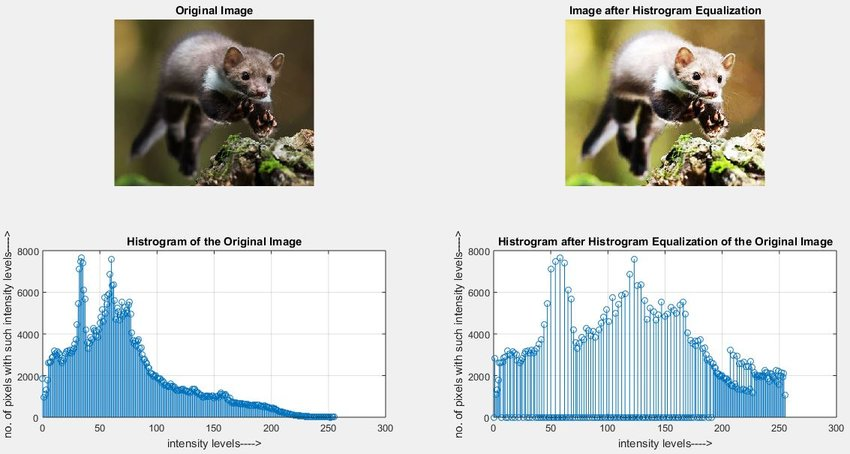


## III. Proposed fuzzy-based method

### 1. Overall Pipeline

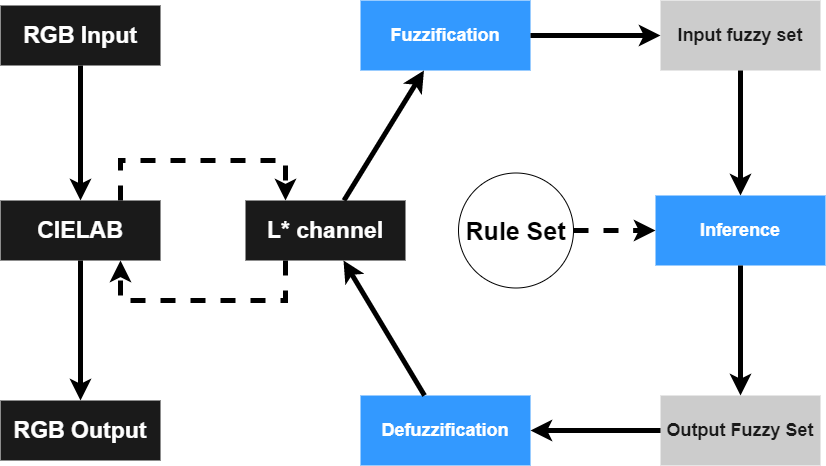

#### Description:

- Convert input image from RGB to CIELAB, progress on L channel

- Calculate the average pixel intensity - M value

- **Fuzzification:** For each pixel, calculate degree of membership of each class based on pixel intensity and M value. $Intensity \in[0, 255]$

- **Inference:** Calculate the output fuzzy set from the input pixel intensity based on the proposed rule set

- **Defuzzification:** For each pixel, calculate centroid value of its output fuzzy set.  $Centroid \in [-50, 305]$

- Normalize output pixel intensity from \[-50, 305\] to \[0, 255\]

- Merge modified L channel to the original AB channels, convert output image from CIELAB to RGB.

### 2. Fuzzification of  Pixel Intensity

In [37]:
# Gaussian Function:
def G(x, mean, std):
    return np.exp(-0.5 * np.square((x - mean) / std))

# Membership Functions:


### 3. Rule Set
- IF input is VeryDark THEN output is ExtremelyDark
- IF input is Dark THEN output is VeryDark
- IF input is SlightlyDark THEN output is Dark
- IF input is SlightlyBright THEN output is Bright
- IF input is Bright THEN output is VeryBright
- IF input is VeryBright THEN output is ExtremelyBright

### 4. Inference and Defuzzication (Mamdani's method)

In [38]:
def OutputFuzzySet(x, f, M, thres):
    x = np.array(x)
    result = f(x, M)
    result[result > thres] = thres
    return result

def AggregateFuzzySets(fuzzy_sets):
    return np.max(np.stack(fuzzy_sets), axis=0)

def Infer(i, M, get_fuzzy_set=False):
    # Calculate degree of membership for each class
    VD = VeryDark(i, M)
    Da = Dark(i, M)
    SD = SlightlyDark(i, M)
    SB = SlightlyBright(i, M)
    Br = Bright(i, M)
    VB = VeryBright(i, M)

    # Fuzzy Inference:
    ...

    # Calculate AggregatedFuzzySet:
    fuzzy_output = AggregateFuzzySets(Inferences)

    # Calculate crisp value of centroid
    if get_fuzzy_set:
        return np.average(x, weights=fuzzy_output), fuzzy_output
    return np.average(x, weights=fuzzy_output)

In [39]:
...

Ellipsis

## IV. Demonstration

In [40]:
# Proposed fuzzy method
def FuzzyContrastEnhance(rgb):
    # Convert RGB to LAB
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)

    # Get L channel
    l = lab[:, :, 0]

    # Calculate M value
    M = np.mean(l)
    if M < 128:
        M = 127 - (127 - M)/2
    else:
        M = 128 + M/2

    # Precompute the fuzzy transform
    ...

    # Apply the transform to l channel
    u, inv = np.unique(l, return_inverse = True)
    l = np.array([FuzzyTransform[i] for i in u])[inv].reshape(l.shape)

    # Min-max scale the output L channel to fit (0, 255):
    Min = np.min(l)
    Max = np.max(l)
    lab[:, :, 0] = (l - Min)/(Max - Min) * 255

    # Convert LAB to RGB
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Traditional method of histogram equalization
def HE(rgb):
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab[:, :, 0] = cv2.equalizeHist(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Contrast Limited Adaptive Histogram Equalization
def CLAHE(rgb):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

### 1. Load sample photos

In [41]:
data = np.array([cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in glob(f'{PATH}/*')])
data.shape

TypeError: 'module' object is not callable

### 2. Apply FCE on sample photos

In [ ]:
...

## V. Evaluation

### 1. Execution Time
**Fuzzy Contrast Enchance**

In [ ]:
%%time
for i in range(10):
    FuzzyContrastEnhance(data[i])

**Traditional HE**

In [ ]:
%%time
for i in range(10):
    HE(data[i])

**CLAHE**

In [ ]:
%%time
for i in range(10):
    CLAHE(data[i])

### 2. Peak Signal-to-Noise Ratio (PSNR)

$PSNR = 10*\log_{10} \frac{MAX^2}{MSE}$

In [ ]:
def MSE(img1, img2):
    return np.mean(np.square(img1 - img2))

def PSNR(Max, MSE):
    return 10*math.log10(Max**2/MSE)

In [ ]:
display(Markdown(f'FCE: {PSNR(255*255, np.mean([MSE(org, FuzzyContrastEnhance(org)) for org in data]))}'))
display(Markdown(f'HE: {PSNR(255*255, np.mean([MSE(org, HE(org)) for org in data]))}'))
display(Markdown(f'CLAHE: {PSNR(255*255, np.mean([MSE(org, CLAHE(org)) for org in data]))}'))

## VI. References

1. Image contrast enhancement using fuzzy logic <br>https://arxiv.org/ftp/arxiv/papers/1809/1809.04529.pdf

2. A fast and efficient color image enhancement method based on fuzzy-logic and histogram <br>http://dx.doi.org/10.1016/j.aeue.2013.08.015